In [1]:
# Step 1: Set up the working directory and import necessary libraries
import os
import torch
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5Model, T5EncoderModel
from sklearn.preprocessing import StandardScaler

# Define the working directory
working_dir = r"C:\Users\user\Desktop\Pratanu\DB2"

# Check if the directory exists
if not os.path.exists(working_dir):
    raise FileNotFoundError(f"Directory {working_dir} does not exist")

# Load the SMILES and proteins data into pandas dataframes
smiles_df = pd.read_csv(os.path.join(working_dir, 'unique_smiles.csv'))
proteins_df = pd.read_csv(os.path.join(working_dir, 'unique_proteins.csv'))

# Print the first few rows to ensure data is loaded correctly
print("First few rows of smiles.csv:")
print(smiles_df.head())

print("\nFirst few rows of proteins.csv:")
print(proteins_df.head())

First few rows of smiles.csv:
  DrugBank ID                                      Ligand SMILES
0          D1  CC[C@H](C)[C@@H]1NC(=O)[C@@H](Cc2ccccc2)NC(=O)...
1          D2  Oc1cc(-c2ncc3c(nc(OCC45CCCN4CCC5)nc3c2F)N2CC3C...
2          D3  Nc1ccc2c(c1)c(-c1ccccc1)n(CCCCCCc1cnnn1CCNc1c3...
3          D4  COc1cc2CCN(CCCCCCc3cnnn3CCNc3c4CCCCc4nc4ccccc3...
4          D5  COc1cc2CCN(CCCCCCc3cnnn3CCNc3c4CCCCc4nc4ccccc3...

First few rows of proteins.csv:
  UniProt ID                                           Sequence
0         P1  MGLAWGLGVLFLMHVCGTNRIPESGGDNSVFDIFELTGAARKGSGR...
1         P2  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2         P3  MRPPQCLLHTPSLASPLLLLLLWLLGGGVGAEGREDAELLVTVRGG...
3         P4  MRKIVVAAIAVSLTTVSITASASADPSKDSKAQVSAAEAGITGTWY...
4         P5  MRPPWYPLHTPSLAFPLLFLLLSLLGGGARAEGREDPQLLVRVRGG...


In [6]:
# Set up device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Initialize ChemBERTa for drugs
tokenizer_chemberta = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model_chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to extract ChemBERTa embeddings for a SMILES string
def get_chemberta_embedding(smiles):
    inputs = tokenizer_chemberta(smiles, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model_chemberta(**inputs)
    # Taking the mean of the hidden states as the embedding
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# Process drugs
drug_embeddings = []
for _, row in tqdm(smiles_df.iterrows(), total=len(smiles_df), desc="Processing drugs"):
    smiles = row['Ligand SMILES']
    drug_id = row['DrugBank ID']
    
    # Get ChemBERTa embeddings
    chemberta_emb = get_chemberta_embedding(smiles)
    
    # Append the DrugBank ID and the embeddings as a row
    drug_embeddings.append([drug_id] + chemberta_emb.tolist())

# Convert to a DataFrame with proper column names
embedding_columns = [f"embedding_dim_{i+1}" for i in range(chemberta_emb.shape[0])]
drug_embeddings_df = pd.DataFrame(drug_embeddings, columns=['DrugBank ID'] + embedding_columns)

# Save drug embeddings to CSV
drug_embeddings_df.to_csv(os.path.join(working_dir, 'ChemBERT_drug_embeddings.csv'), index=False)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing drugs: 100%|██████████████████████████████████████████████████████████| 30862/30862 [17:15<00:00, 29.81it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
C:\User

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\Desktop\\Pratanu\\DB2\\proteins.csv'

In [14]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from tape import ProteinBertModel, TAPETokenizer
from tqdm import tqdm

# Initialize the tokenizer and model for TAPE (Protein embeddings)
tokenizer_tape = TAPETokenizer(vocab="iupac")
model_tape = ProteinBertModel.from_pretrained("bert-base")

# Function to compute Morgan fingerprints (for drugs)
def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return np.zeros(n_bits)  # Return a zero vector for invalid SMILES
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Function to clean and validate protein sequences
def clean_sequence(sequence):
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
    cleaned_sequence = ''.join([aa for aa in sequence if aa.upper() in valid_amino_acids])
    return cleaned_sequence.upper()

# Function to compute TAPE embeddings (for proteins)
def get_tape_embedding(sequence):
    # Clean and validate the sequence
    cleaned_sequence = clean_sequence(sequence)
    if len(cleaned_sequence) == 0:
        print(f"Invalid sequence: {sequence}")
        return np.zeros(model_tape.config.hidden_size)  # Return a zero vector for invalid sequences

    # Tokenize the sequence
    tokens = tokenizer_tape.tokenize(cleaned_sequence)
    input_ids = torch.tensor([tokenizer_tape.convert_tokens_to_ids(tokens)]).to(torch.long)
    
    # Forward pass through TAPE model
    with torch.no_grad():
        outputs = model_tape(input_ids)
    
    # Access the first element in the tuple (final hidden states)
    hidden_states = outputs[0]
    
    # Use mean pooling over all tokens to get a fixed-size embedding
    embedding = hidden_states.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Initialize lists to store the results
drug_morgan_fps = []
drug_ids = []
protein_tape_embeddings = []
protein_ids = []

# Extract Morgan fingerprints for drugs
print("Processing Morgan fingerprints for drugs...")
for _, row in tqdm(smiles_df.iterrows(), total=len(smiles_df)):
    smiles = row['Ligand SMILES']
    drug_id = row['DrugBank ID']
    
    # Compute Morgan fingerprint
    morgan_fp = get_morgan_fingerprint(smiles)
    
    # Store the results
    drug_morgan_fps.append(morgan_fp)
    drug_ids.append(drug_id)

# Convert drug fingerprints to a numpy array and save to a CSV file
drug_morgan_fps = np.array(drug_morgan_fps)
drug_fps_df = pd.DataFrame(drug_morgan_fps, columns=[f'fingerprint_{i+1}' for i in range(drug_morgan_fps.shape[1])])
drug_fps_df.insert(0, 'DrugBank ID', drug_ids)  # Insert DrugBank ID as the first column
drug_fps_df.to_csv(os.path.join(working_dir, 'drug_morgan_fingerprints.csv'), index=False)
print("Morgan fingerprints for drugs saved to 'drug_morgan_fingerprints.csv'.")

# Extract TAPE embeddings for proteins
print("Processing TAPE embeddings for proteins...")
for _, row in tqdm(proteins_df.iterrows(), total=len(proteins_df)):
    sequence = row['Sequence']
    protein_id = row['UniProt ID']
    
    # Compute TAPE embedding
    try:
        tape_emb = get_tape_embedding(sequence)
        protein_tape_embeddings.append(tape_emb)
        protein_ids.append(protein_id)
    except Exception as e:
        print(f"Error processing protein {protein_id}: {e}")
        continue  # Skip this protein and move on to the next

# Convert protein embeddings to a numpy array and save to a CSV file
protein_tape_embeddings = np.array(protein_tape_embeddings)
protein_emb_df = pd.DataFrame(protein_tape_embeddings, columns=[f'embedding_dim_{i+1}' for i in range(protein_tape_embeddings.shape[1])])
protein_emb_df.insert(0, 'UniProt ID', protein_ids)  # Insert UniProt ID as the first column
protein_emb_df.to_csv(os.path.join(working_dir, 'protein_tape_embeddings.csv'), index=False)
print("TAPE embeddings for proteins saved to 'protein_tape_embeddings.csv'.")

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tape\models\modeling_utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolve

Processing Morgan fingerprints for drugs...


  0%|                                                                                        | 0/30862 [00:00<?, ?it/s][15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenerator
[15:46:55] DEPRECATION WARNING: please use MorganGenera

Invalid SMILES: CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1
Invalid SMILES: CNc1cc(Nc2cccn([C@@H]3CC[C@@H](CC3)[O]3CCOCC3)c2=O)nc2c(cnn12)C(=O)N[C@H]1C[C@H]1F


[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC


[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerator
[15:47:00] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1


[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerator
[15:47:03] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CNc1cc(Nc2cccn([C@@H]3C[C@@H](C3)OC)c2=O)nc2c(cnn12)C(=O)N[H]1CC[C@@]1(C)OC


[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerator
[15:47:06] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3ccc(NC[C@H]4CC[C@](C)(O)CC4)c(c3)[N+]([O-])=O)c(Oc3cnc4[nH]ccc4c3)c2)=C(C1)C12CC([H]C(F)F)(C1)C2


[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerator
[15:47:23] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21


[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerator
[15:47:29] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: C\[O]=c1\[nH]cc(cc1C(F)(F)F)C(=O)Nc1cc(c(F)cc1N1CCN(C)[C@@H](C)C1)-c1cnc(nc1)N1CCOCC1


[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: COC(=O)CCC\C(N)=C\NCCOCCOCCOCCC(=O)NCCNC(=O)c1c(C)nc(\C=C2/C(=O)Nc3ccc(F)cc23)c1C


 43%|████████████████████████████████▏                                          | 13233/30862 [00:35<00:46, 377.93it/s][15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:30] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenera

Invalid SMILES: CC(C)[N]1=[C](=O)C(Oc2nc3ncc(Oc4ccnc(NC(C)=O)c4)cc3n2C)=CC(=C1)C1CC1


[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerator
[15:47:31] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: C[C@@H](Nc1nc(C)nc2n(C)c(=O)c(cc12)N1CC2(COC2)C1)c1cccc([H]C(F)F)c1F


[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerator
[15:47:37] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CSc1cnc(N[C@H]2CC[C@@H](C2)Nc2ccc(cn2)-n2ncccc2O)nc1


[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerator
[15:47:43] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](C)N4)C(F)(F)F)c3)c2cc1OC


 60%|████████████████████████████████████████████▊                              | 18425/30862 [00:49<00:36, 343.92it/s][15:47:44] DEPRECATION WARNING: please use MorganGenerator
[15:47:44] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenerator
[15:47:45] DEPRECATION WARNING: please use MorganGenera

Invalid SMILES: COc1cc2ncnc(Oc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC


[15:47:47] DEPRECATION WARNING: please use MorganGenerator
[15:47:47] DEPRECATION WARNING: please use MorganGenerator
[15:47:47] DEPRECATION WARNING: please use MorganGenerator
[15:47:47] DEPRECATION WARNING: please use MorganGenerator
[15:47:47] DEPRECATION WARNING: please use MorganGenerator
[15:47:47] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerator
[15:47:48] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: COc1cc2ncnc(Sc3cccc(NC(=O)NC4=CC(=[N](N4)c4ccccc4)C(F)(F)F)c3)c2cc1OC


[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerator
[15:47:53] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CC(=O)Nc1cc(Oc2ccc3nc(NC4=[N](NC(=C4)C(C)(C)C)[C@@H]4CCOC4)n(C)c3c2)ccn1


[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerator
[15:47:58] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CC(C)[C@@H](C(=O)N1C[C@H](O)C[C@H]1C1=NOC(N1)(c1ccccc1)c1ccccc1)C1=[O]N=C(C)C1


[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerator
[15:48:05] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: CC(C)[C@H](C(=O)N1C[C@H](O)C[C@H]1C1=NOC(N1)(c1ccccc1)c1ccccc1)C1=[O]N=C(C)C1


[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerator
[15:48:13] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: Cc1ccc(F)c(NC(=O)Nc2cnn(c2)-c2cccc3nnc(N)c23)c1


[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerator
[15:48:15] DEPRECATION WARNING: please use MorganGenerat

Invalid SMILES: C[O]=C(N[C@@H](CNC(=O)c1ccc2COB(O)c2c1)C(O)=O)c1ccc2COBc2c1


[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerator
[15:48:16] DEPRECATION WARNING: please use MorganGenerat

Morgan fingerprints for drugs saved to 'drug_morgan_fingerprints.csv'.
Processing TAPE embeddings for proteins...


100%|██████████████████████████████████████████████████████████████████████████████| 2186/2186 [29:56<00:00,  1.22it/s]


TAPE embeddings for proteins saved to 'protein_tape_embeddings.csv'.


In [15]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from tape import ProteinBertModel, TAPETokenizer
from tqdm import tqdm


# Initialize the tokenizer and model for TAPE (Protein embeddings)
tokenizer_tape = TAPETokenizer(vocab="iupac")
model_tape = ProteinBertModel.from_pretrained("bert-base")

# Function to compute Morgan fingerprints (for drugs)
def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)  # Return a zero vector for invalid SMILES
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Function to compute TAPE embeddings (for proteins)
def get_tape_embedding(sequence):
    # Tokenize the sequence
    tokens = tokenizer_tape.tokenize(sequence)
    input_ids = torch.tensor([tokenizer_tape.convert_tokens_to_ids(tokens)]).to(torch.long)
    
    # Forward pass through TAPE model
    with torch.no_grad():
        outputs = model_tape(input_ids)
    
    # Access the first element in the tuple (final hidden states)
    hidden_states = outputs[0]
    
    # Use mean pooling over all tokens to get a fixed-size embedding
    embedding = hidden_states.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Initialize lists to store the results
drug_morgan_fps = []
drug_ids = []
protein_tape_embeddings = []
protein_ids = []

# Extract Morgan fingerprints for drugs
print("Processing Morgan fingerprints for drugs...")
for _, row in tqdm(smiles_df.iterrows(), total=len(smiles_df)):
    smiles = row['Ligand SMILES']
    drug_id = row['DrugBank ID']
    
    # Compute Morgan fingerprint
    morgan_fp = get_morgan_fingerprint(smiles)
    
    # Store the results
    drug_morgan_fps.append(morgan_fp)
    drug_ids.append(drug_id)

# Convert drug fingerprints to a numpy array and save to a CSV file
drug_morgan_fps = np.array(drug_morgan_fps)
drug_fps_df = pd.DataFrame(drug_morgan_fps, columns=[f'fingerprint_{i+1}' for i in range(drug_morgan_fps.shape[1])])
drug_fps_df.insert(0, 'DrugBank ID', drug_ids)  # Insert DrugBank ID as the first column
drug_fps_df.to_csv(os.path.join(working_dir, 'drug_morgan_fingerprints.csv'), index=False)
print("Morgan fingerprints for drugs saved to 'drug_morgan_fingerprints.csv'.")

# Extract TAPE embeddings for proteins
print("Processing TAPE embeddings for proteins...")
for _, row in tqdm(proteins_df.iterrows(), total=len(proteins_df)):
    sequence = row['Sequence']
    protein_id = row['UniProt ID']
    
    # Compute TAPE embedding
    tape_emb = get_tape_embedding(sequence)
    
    # Store the results
    protein_tape_embeddings.append(tape_emb)
    protein_ids.append(protein_id)

# Convert protein embeddings to a numpy array and save to a CSV file
protein_tape_embeddings = np.array(protein_tape_embeddings)
protein_emb_df = pd.DataFrame(protein_tape_embeddings, columns=[f'embedding_dim_{i+1}' for i in range(protein_tape_embeddings.shape[1])])
protein_emb_df.insert(0, 'UniProt ID', protein_ids)  # Insert UniProt ID as the first column
protein_emb_df.to_csv(os.path.join(working_dir, 'protein_tape_embeddings.csv'), index=False)
print("TAPE embeddings for proteins saved to 'protein_tape_embeddings.csv'.")

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tape\models\modeling_utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolve

Processing Morgan fingerprints for drugs...


  0%|                                                                                        | 0/30862 [00:00<?, ?it/s][16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenerator
[16:18:57] DEPRECATION WARNING: please use MorganGenera

KeyError: "Unrecognized token: 'm'"

In [18]:
#80-10-10 split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import math
import os


# Step 1: Load the embeddings and Kd values from CSV files
chemberta_drug_embeddings = pd.read_csv(os.path.join(working_dir, 'ChemBERT_drug_embeddings.csv'))
morgan_drug_fingerprints = pd.read_csv(os.path.join(working_dir, 'drug_morgan_fingerprints.csv'))
prostt5_protein_embeddings = pd.read_csv(os.path.join(working_dir, 'protein_prostt5_embeddings.csv'))
tape_protein_embeddings = pd.read_csv(os.path.join(working_dir, 'protein_tape_embeddings.csv'))
kd_values = pd.read_csv(os.path.join(working_dir, 'Links_Kd_Scores.csv'))  # with 'DrugBank ID', 'UniProt ID', 'Kd'

# Step 2: Log-normalize the Kd values
kd_values['Log_Kd'] = kd_values['Kd(nM)'].apply(lambda x: math.log10(x + 1))  # Adding 1 to avoid log(0)

# Step 3: Merge embeddings
# Merge drug embeddings (ChemBERTa + Morgan fingerprints) using 'DrugBank ID'
drug_embeddings = pd.merge(chemberta_drug_embeddings, morgan_drug_fingerprints, on='DrugBank ID')

# Merge protein embeddings (ProstT5 + TAPE embeddings) using 'UniProt ID'
protein_embeddings = pd.merge(prostt5_protein_embeddings, tape_protein_embeddings, on='UniProt ID')

# Merge the drug-protein pairs with Kd values
merged_df = pd.merge(kd_values, drug_embeddings, on='DrugBank ID')
merged_df = pd.merge(merged_df, protein_embeddings, on='UniProt ID')

# Step 4: Z-score normalization for ChemBERTa, ProstT5, and TAPE embeddings
chemberta_cols = [col for col in chemberta_drug_embeddings.columns if 'embedding_dim_' in col]
prostt5_cols = [col for col in prostt5_protein_embeddings.columns if 'embedding_dim_' in col]
tape_cols = [col for col in tape_protein_embeddings.columns if 'embedding_dim_' in col]
morgan_cols = [col for col in morgan_drug_fingerprints.columns if 'fingerprint_' in col]  # No normalization for Morgan

# Normalizing ChemBERTa, ProstT5, and TAPE embeddings
scaler_chemberta = StandardScaler()
scaler_prostt5 = StandardScaler()
scaler_tape = StandardScaler()

# Normalize embeddings
merged_df[chemberta_cols] = scaler_chemberta.fit_transform(merged_df[chemberta_cols])
merged_df[prostt5_cols] = scaler_prostt5.fit_transform(merged_df[prostt5_cols])
merged_df[tape_cols] = scaler_tape.fit_transform(merged_df[tape_cols])

# Step 5: Attention mechanism to combine embeddings
class AttentionCombiner(nn.Module):
    def __init__(self, chemberta_dim, morgan_dim, prostt5_dim, tape_dim):
        super(AttentionCombiner, self).__init__()
        self.chemberta_fc = nn.Linear(chemberta_dim, chemberta_dim)
        self.morgan_fc = nn.Linear(morgan_dim, morgan_dim)
        self.prostt5_fc = nn.Linear(prostt5_dim, prostt5_dim)
        self.tape_fc = nn.Linear(tape_dim, tape_dim)
        
        self.attention_layer = nn.Linear(chemberta_dim + morgan_dim + prostt5_dim + tape_dim, 1)

    def forward(self, chemberta, morgan, prostt5, tape):
        # Apply linear layers
        chemberta = self.chemberta_fc(chemberta)
        morgan = self.morgan_fc(morgan)
        prostt5 = self.prostt5_fc(prostt5)
        tape = self.tape_fc(tape)
        
        # Concatenate embeddings
        combined = torch.cat([chemberta, morgan, prostt5, tape], dim=1)
        
        # Apply attention
        attention_weights = torch.softmax(self.attention_layer(combined), dim=1)
        
        # Compute weighted combination
        combined_embedding = attention_weights * combined
        return combined_embedding

# Convert embeddings to tensors and apply attention mechanism
chemberta_tensor = torch.tensor(merged_df[chemberta_cols].values, dtype=torch.float32)
morgan_tensor = torch.tensor(merged_df[morgan_cols].values, dtype=torch.float32)
prostt5_tensor = torch.tensor(merged_df[prostt5_cols].values, dtype=torch.float32)
tape_tensor = torch.tensor(merged_df[tape_cols].values, dtype=torch.float32)

# Initialize attention combiner
combiner = AttentionCombiner(
    chemberta_dim=len(chemberta_cols),
    morgan_dim=len(morgan_cols),
    prostt5_dim=len(prostt5_cols),
    tape_dim=len(tape_cols)
)

# Apply attention mechanism to get the combined embedding for each drug-protein pair
with torch.no_grad():
    combined_embeddings = combiner(chemberta_tensor, morgan_tensor, prostt5_tensor, tape_tensor)

# Convert combined embeddings back to DataFrame
combined_embeddings_df = pd.DataFrame(combined_embeddings.numpy())

# Step 6: Add combined embeddings and log-normalized Kd values to final dataset
final_dataset = pd.concat([merged_df[['DrugBank ID', 'UniProt ID', 'Log_Kd']], combined_embeddings_df], axis=1)

# Step 7: Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(final_dataset, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)  # 20% of 90% goes to validation

# Save the splits to CSV files in the working directory
train_df.to_csv(os.path.join(working_dir, 'train_dataset.csv'), index=False)
val_df.to_csv(os.path.join(working_dir, 'val_dataset.csv'), index=False)
test_df.to_csv(os.path.join(working_dir, 'test_dataset.csv'), index=False)

# Print a message to confirm successful completion
print("Data processing complete! Training, validation, and test datasets saved in the working directory.")

Data processing complete! Training, validation, and test datasets saved in the working directory.


In [25]:
#70-15-15 split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import math
import os


# Step 1: Load the embeddings and Kd values from CSV files
chemberta_drug_embeddings = pd.read_csv(os.path.join(working_dir, 'ChemBERT_drug_embeddings.csv'))
morgan_drug_fingerprints = pd.read_csv(os.path.join(working_dir, 'drug_morgan_fingerprints.csv'))
prostt5_protein_embeddings = pd.read_csv(os.path.join(working_dir, 'protein_prostt5_embeddings.csv'))
tape_protein_embeddings = pd.read_csv(os.path.join(working_dir, 'protein_tape_embeddings.csv'))
kd_values = pd.read_csv(os.path.join(working_dir, 'Links_Kd_Scores.csv'))  # with 'DrugBank ID', 'UniProt ID', 'Kd'

# Step 2: Log-normalize the Kd values
kd_values['Log_Kd'] = kd_values['Kd(nM)'].apply(lambda x: math.log10(x + 1))  # Adding 1 to avoid log(0)

# Step 3: Merge embeddings
# Merge drug embeddings (ChemBERTa + Morgan fingerprints) using 'DrugBank ID'
drug_embeddings = pd.merge(chemberta_drug_embeddings, morgan_drug_fingerprints, on='DrugBank ID')

# Merge protein embeddings (ProstT5 + TAPE embeddings) using 'UniProt ID'
protein_embeddings = pd.merge(prostt5_protein_embeddings, tape_protein_embeddings, on='UniProt ID')

# Merge the drug-protein pairs with Kd values
merged_df = pd.merge(kd_values, drug_embeddings, on='DrugBank ID')
merged_df = pd.merge(merged_df, protein_embeddings, on='UniProt ID')

# Step 4: Z-score normalization for ChemBERTa, ProstT5, and TAPE embeddings
chemberta_cols = [col for col in chemberta_drug_embeddings.columns if 'embedding_dim_' in col]
prostt5_cols = [col for col in prostt5_protein_embeddings.columns if 'embedding_dim_' in col]
tape_cols = [col for col in tape_protein_embeddings.columns if 'embedding_dim_' in col]
morgan_cols = [col for col in morgan_drug_fingerprints.columns if 'fingerprint_' in col]  # No normalization for Morgan

# Normalizing ChemBERTa, ProstT5, and TAPE embeddings
scaler_chemberta = StandardScaler()
scaler_prostt5 = StandardScaler()
scaler_tape = StandardScaler()

# Normalize embeddings
merged_df[chemberta_cols] = scaler_chemberta.fit_transform(merged_df[chemberta_cols])
merged_df[prostt5_cols] = scaler_prostt5.fit_transform(merged_df[prostt5_cols])
merged_df[tape_cols] = scaler_tape.fit_transform(merged_df[tape_cols])

# Step 5: Attention mechanism to combine embeddings
class AttentionCombiner(nn.Module):
    def __init__(self, chemberta_dim, morgan_dim, prostt5_dim, tape_dim):
        super(AttentionCombiner, self).__init__()
        self.chemberta_fc = nn.Linear(chemberta_dim, chemberta_dim)
        self.morgan_fc = nn.Linear(morgan_dim, morgan_dim)
        self.prostt5_fc = nn.Linear(prostt5_dim, prostt5_dim)
        self.tape_fc = nn.Linear(tape_dim, tape_dim)
        
        self.attention_layer = nn.Linear(chemberta_dim + morgan_dim + prostt5_dim + tape_dim, 1)

    def forward(self, chemberta, morgan, prostt5, tape):
        # Apply linear layers
        chemberta = self.chemberta_fc(chemberta)
        morgan = self.morgan_fc(morgan)
        prostt5 = self.prostt5_fc(prostt5)
        tape = self.tape_fc(tape)
        
        # Concatenate embeddings
        combined = torch.cat([chemberta, morgan, prostt5, tape], dim=1)
        
        # Apply attention
        attention_weights = torch.softmax(self.attention_layer(combined), dim=1)
        
        # Compute weighted combination
        combined_embedding = attention_weights * combined
        return combined_embedding

# Convert embeddings to tensors and apply attention mechanism
chemberta_tensor = torch.tensor(merged_df[chemberta_cols].values, dtype=torch.float32)
morgan_tensor = torch.tensor(merged_df[morgan_cols].values, dtype=torch.float32)
prostt5_tensor = torch.tensor(merged_df[prostt5_cols].values, dtype=torch.float32)
tape_tensor = torch.tensor(merged_df[tape_cols].values, dtype=torch.float32)

# Initialize attention combiner
combiner = AttentionCombiner(
    chemberta_dim=len(chemberta_cols),
    morgan_dim=len(morgan_cols),
    prostt5_dim=len(prostt5_cols),
    tape_dim=len(tape_cols)
)

# Apply attention mechanism to get the combined embedding for each drug-protein pair
with torch.no_grad():
    combined_embeddings = combiner(chemberta_tensor, morgan_tensor, prostt5_tensor, tape_tensor)

# Convert combined embeddings back to DataFrame
combined_embeddings_df = pd.DataFrame(combined_embeddings.numpy())

# Step 6: Add combined embeddings and log-normalized Kd values to final dataset
final_dataset = pd.concat([merged_df[['DrugBank ID', 'UniProt ID', 'Log_Kd']], combined_embeddings_df], axis=1)

# Step 7: Split the dataset into training (70%) and remaining (30%)
train_df, remaining_df = train_test_split(final_dataset, test_size=0.3, random_state=42)

# Step 8: Split the remaining dataset into validation (15%) and test (15%)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Save the splits to CSV files in the working directory
train_df.to_csv(os.path.join(working_dir, 'train_dataset.csv'), index=False)
val_df.to_csv(os.path.join(working_dir, 'val_dataset.csv'), index=False)
test_df.to_csv(os.path.join(working_dir, 'test_dataset.csv'), index=False)

# Print a message to confirm successful completion
print("Data processing complete! Training, validation, and test datasets saved in the working directory.")

Data processing complete! Training, validation, and test datasets saved in the working directory.


In [3]:
#70-20-10 split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import math
import os


# Step 1: Load the embeddings and Kd values from CSV files
chemberta_drug_embeddings = pd.read_csv(os.path.join(working_dir, 'ChemBERT_drug_embeddings.csv'))
morgan_drug_fingerprints = pd.read_csv(os.path.join(working_dir, 'drug_morgan_fingerprints.csv'))
prostt5_protein_embeddings = pd.read_csv(os.path.join(working_dir, 'protein_prostt5_embeddings.csv'))
tape_protein_embeddings = pd.read_csv(os.path.join(working_dir, 'protein_tape_embeddings.csv'))
kd_values = pd.read_csv(os.path.join(working_dir, 'Links_Kd_Scores.csv'))  # with 'DrugBank ID', 'UniProt ID', 'Kd'

# Step 2: Log-normalize the Kd values
kd_values['Log_Kd'] = kd_values['Kd(nM)'].apply(lambda x: math.log10(x + 1))  # Adding 1 to avoid log(0)

# Step 3: Merge embeddings
# Merge drug embeddings (ChemBERTa + Morgan fingerprints) using 'DrugBank ID'
drug_embeddings = pd.merge(chemberta_drug_embeddings, morgan_drug_fingerprints, on='DrugBank ID')

# Merge protein embeddings (ProstT5 + TAPE embeddings) using 'UniProt ID'
protein_embeddings = pd.merge(prostt5_protein_embeddings, tape_protein_embeddings, on='UniProt ID')

# Merge the drug-protein pairs with Kd values
merged_df = pd.merge(kd_values, drug_embeddings, on='DrugBank ID')
merged_df = pd.merge(merged_df, protein_embeddings, on='UniProt ID')

# Step 4: Z-score normalization for ChemBERTa, ProstT5, and TAPE embeddings
chemberta_cols = [col for col in chemberta_drug_embeddings.columns if 'embedding_dim_' in col]
prostt5_cols = [col for col in prostt5_protein_embeddings.columns if 'embedding_dim_' in col]
tape_cols = [col for col in tape_protein_embeddings.columns if 'embedding_dim_' in col]
morgan_cols = [col for col in morgan_drug_fingerprints.columns if 'fingerprint_' in col]  # No normalization for Morgan

# Normalizing ChemBERTa, ProstT5, and TAPE embeddings
scaler_chemberta = StandardScaler()
scaler_prostt5 = StandardScaler()
scaler_tape = StandardScaler()

# Normalize embeddings
merged_df[chemberta_cols] = scaler_chemberta.fit_transform(merged_df[chemberta_cols])
merged_df[prostt5_cols] = scaler_prostt5.fit_transform(merged_df[prostt5_cols])
merged_df[tape_cols] = scaler_tape.fit_transform(merged_df[tape_cols])

# Step 5: Attention mechanism to combine embeddings
class AttentionCombiner(nn.Module):
    def __init__(self, chemberta_dim, morgan_dim, prostt5_dim, tape_dim):
        super(AttentionCombiner, self).__init__()
        self.chemberta_fc = nn.Linear(chemberta_dim, chemberta_dim)
        self.morgan_fc = nn.Linear(morgan_dim, morgan_dim)
        self.prostt5_fc = nn.Linear(prostt5_dim, prostt5_dim)
        self.tape_fc = nn.Linear(tape_dim, tape_dim)
        
        self.attention_layer = nn.Linear(chemberta_dim + morgan_dim + prostt5_dim + tape_dim, 1)

    def forward(self, chemberta, morgan, prostt5, tape):
        # Apply linear layers
        chemberta = self.chemberta_fc(chemberta)
        morgan = self.morgan_fc(morgan)
        prostt5 = self.prostt5_fc(prostt5)
        tape = self.tape_fc(tape)
        
        # Concatenate embeddings
        combined = torch.cat([chemberta, morgan, prostt5, tape], dim=1)
        
        # Apply attention
        attention_weights = torch.softmax(self.attention_layer(combined), dim=1)
        
        # Compute weighted combination
        combined_embedding = attention_weights * combined
        return combined_embedding

# Convert embeddings to tensors and apply attention mechanism
chemberta_tensor = torch.tensor(merged_df[chemberta_cols].values, dtype=torch.float32)
morgan_tensor = torch.tensor(merged_df[morgan_cols].values, dtype=torch.float32)
prostt5_tensor = torch.tensor(merged_df[prostt5_cols].values, dtype=torch.float32)
tape_tensor = torch.tensor(merged_df[tape_cols].values, dtype=torch.float32)

# Initialize attention combiner
combiner = AttentionCombiner(
    chemberta_dim=len(chemberta_cols),
    morgan_dim=len(morgan_cols),
    prostt5_dim=len(prostt5_cols),
    tape_dim=len(tape_cols)
)

# Apply attention mechanism to get the combined embedding for each drug-protein pair
with torch.no_grad():
    combined_embeddings = combiner(chemberta_tensor, morgan_tensor, prostt5_tensor, tape_tensor)

# Convert combined embeddings back to DataFrame
combined_embeddings_df = pd.DataFrame(combined_embeddings.numpy())

# Step 6: Add combined embeddings and log-normalized Kd values to final dataset
final_dataset = pd.concat([merged_df[['DrugBank ID', 'UniProt ID', 'Log_Kd']], combined_embeddings_df], axis=1)

# Step 7: Split the dataset into training (70%) and remaining (30%)
train_df, remaining_df = train_test_split(final_dataset, test_size=0.3, random_state=42)

# Step 8: Split the remaining dataset into validation (20%) and test (10%)
val_df, test_df = train_test_split(remaining_df, test_size=1/3, random_state=42)

# Save the splits to CSV files in the working directory
train_df.to_csv(os.path.join(working_dir, 'train_dataset1.csv'), index=False)
val_df.to_csv(os.path.join(working_dir, 'val_dataset1.csv'), index=False)
test_df.to_csv(os.path.join(working_dir, 'test_dataset1.csv'), index=False)

# Print a message to confirm successful completion
print("Data processing complete! Training, validation, and test datasets saved in the working directory.")

Data processing complete! Training, validation, and test datasets saved in the working directory.


In [10]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_file = os.path.join(working_dir, 'train_dataset.csv')
val_file = os.path.join(working_dir, 'val_dataset.csv')
test_file = os.path.join(working_dir, 'test_dataset.csv')

# Dataset class
class KDDataset(Dataset):
    def __init__(self, data):
        self.drug_protein_embedding = data.iloc[:, 3:].values  # All embeddings (drug + protein)
        self.log_kd = data['Log_Kd'].values

    def __len__(self):
        return len(self.log_kd)

    def __getitem__(self, idx):
        return torch.tensor(self.drug_protein_embedding[idx], dtype=torch.float32), torch.tensor(self.log_kd[idx], dtype=torch.float32)

# Load datasets
def load_data(file_path):
    data = pd.read_csv(file_path)
    return KDDataset(data)

# Load the datasets
train_dataset = load_data(train_file)
val_dataset = load_data(val_file)
test_dataset = load_data(test_file)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# FCNN Model
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Get the input dimension
input_dim = train_dataset[0][0].shape[0]

# Instantiate the model
model = FCNN(input_dim).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop (without early stopping)
def train_model(model, train_loader, val_loader, num_epochs=50):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            drug_embedding, log_kd = batch
            drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
            
            optimizer.zero_grad()
            outputs = model(drug_embedding)
            loss = criterion(outputs.squeeze(), log_kd)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                drug_embedding, log_kd = batch
                drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
                outputs = model(drug_embedding)
                loss = criterion(outputs.squeeze(), log_kd)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses


#evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in test_loader:
            drug_embedding, log_kd = batch
            drug_embedding = drug_embedding.to(device)
            log_kd = log_kd.to(device)

            outputs = model(drug_embedding)

            loss = criterion(outputs.squeeze(), log_kd)
            test_loss += loss.item()

            predictions.append(outputs.cpu().numpy())
            targets.append(log_kd.cpu().numpy())

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100  # MAPE in percentage

    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Test MSE: {mse:.4f}, Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}, Test R²: {r2:.4f}, Test MAPE: {mape:.2f}%")
    
    return mse, rmse, mae, r2, mape

# Function to plot training and validation loss
def plot_training_history(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

# Train the model
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader)

# Plot training and validation loss
plot_training_history(train_losses, val_losses)

# Evaluate the model on the test set and gather metrics
mse, rmse, mae, r2, mape = evaluate_model(trained_model, test_loader)

# Visualize the additional metrics
def plot_metrics(mse, rmse, mae, r2, mape):
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }
    plt.figure()
    plt.bar(metrics.keys(), metrics.values())
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Evaluation Metrics on Test Set')
    plt.show()

# Plot evaluation metrics
plot_metrics(mse, rmse, mae, r2, mape)

# Save the model
torch.save(trained_model.state_dict(), os.path.join(working_dir, 'fcnn_model.pth'))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [27]:
#Updated FCNN from python
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class
class KDDataset(Dataset):
    def __init__(self, data):
        self.drug_protein_embedding = data.iloc[:, 3:].values  # All embeddings (drug + protein)
        self.log_kd = data['Log_Kd'].values

    def __len__(self):
        return len(self.log_kd)

    def __getitem__(self, idx):
        return torch.tensor(self.drug_protein_embedding[idx], dtype=torch.float32), torch.tensor(self.log_kd[idx], dtype=torch.float32)

# Load datasets
def load_data(file_path):
    data = pd.read_csv(file_path)
    return KDDataset(data)

# Define paths
train_file = os.path.join(working_dir, 'train_dataset.csv')
val_file = os.path.join(working_dir, 'val_dataset.csv')
test_file = os.path.join(working_dir, 'test_dataset.csv')

# Load the datasets
train_dataset = load_data(train_file)
val_dataset = load_data(val_file)
test_dataset = load_data(test_file)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# FCNN Model with Dropout and Batch Normalization
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)  # Output layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Get the input dimension
input_dim = train_dataset[0][0].shape[0]

# Instantiate the model
model = FCNN(input_dim).to(device)

# Define optimizer and loss function with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping implementation
def train_model_with_early_stopping(model, train_loader, val_loader, num_epochs=100, patience=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            drug_embedding, log_kd = batch
            drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
            
            optimizer.zero_grad()
            outputs = model(drug_embedding)
            loss = criterion(outputs.squeeze(), log_kd)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                drug_embedding, log_kd = batch
                drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
                outputs = model(drug_embedding)
                loss = criterion(outputs.squeeze(), log_kd)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping criteria
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'C:/Users/user/Desktop/Pratanu/DB2/best_model1.pth')  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
        
        # Adjust the learning rate based on validation loss
        scheduler.step(val_loss)

    return model, train_losses, val_losses

# Training the model
trained_model, train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader)

# Load the best model
trained_model.load_state_dict(torch.load('C:/Users/user/Desktop/Pratanu/DB2/best_model1.pth'))

# Plot training and validation loss
def plot_training_history(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_training_history(train_losses, val_losses)

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in test_loader:
            drug_embedding, log_kd = batch
            drug_embedding = drug_embedding.to(device)
            log_kd = log_kd.to(device)

            outputs = model(drug_embedding)

            loss = criterion(outputs.squeeze(), log_kd)
            test_loss += loss.item()

            predictions.append(outputs.cpu().numpy())
            targets.append(log_kd.cpu().numpy())

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100  # MAPE in percentage

    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Test MSE: {mse:.4f}, Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}, Test R²: {r2:.4f}, Test MAPE: {mape:.2f}%")
    
    return mse, rmse, mae, r2, mape

# Evaluate the model
mse, rmse, mae, r2, mape = evaluate_model(trained_model, test_loader)

# Plot evaluation metrics
def plot_metrics(mse, rmse, mae, r2, mape):
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }
    plt.figure()
    plt.bar(metrics.keys(), metrics.values())
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Evaluation Metrics on Test Set')
    plt.show()

plot_metrics(mse, rmse, mae, r2, mape)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] - Train Loss: 1.4006, Val Loss: 1.0770
Epoch [2/100] - Train Loss: 1.1232, Val Loss: 0.9517
Epoch [3/100] - Train Loss: 1.0512, Val Loss: 0.9827
Epoch [4/100] - Train Loss: 1.0043, Val Loss: 0.8834
Epoch [5/100] - Train Loss: 0.9633, Val Loss: 0.8541
Epoch [6/100] - Train Loss: 0.9320, Val Loss: 0.8590
Epoch [7/100] - Train Loss: 0.9091, Val Loss: 0.8238
Epoch [8/100] - Train Loss: 0.8869, Val Loss: 0.8003
Epoch [9/100] - Train Loss: 0.8630, Val Loss: 0.7918
Epoch [10/100] - Train Loss: 0.8468, Val Loss: 0.7853
Epoch [11/100] - Train Loss: 0.8370, Val Loss: 0.7688
Epoch [12/100] - Train Loss: 0.8260, Val Loss: 0.7591
Epoch [13/100] - Train Loss: 0.8116, Val Loss: 0.7653
Epoch [14/100] - Train Loss: 0.8022, Val Loss: 0.7455
Epoch [15/100] - Train Loss: 0.7940, Val Loss: 0.7293
Epoch [16/100] - Train Loss: 0.7834, Val Loss: 0.7468
Epoch [17/100] - Train Loss: 0.7758, Val Loss: 0.7429
Epoch [18/100] - Train Loss: 0.7722, Val Loss: 0.7086
Epoch [19/100] - Train Loss: 0.7655, 

C:\Users\user\AppData\Local\Temp\ipykernel_18408\263522520.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('best_model.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

[I 2024-10-21 09:44:51,346] A new study created in memory with name: no-name-36a4dddf-f13e-480b-bd53-f825afd495fe
C:\Users\user\AppData\Local\Temp\ipykernel_25820\1245620458.py:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
C:\Users\user\AppData\Local\Temp\ipykernel_25820\1245620458.py:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256] wh

Early stopping triggered.


[I 2024-10-21 16:57:47,840] Trial 16 finished with value: 0.5661063484342239 and parameters: {'lr': 0.0004894742964618145, 'batch_size': 32, 'dropout_rate': 0.24124630269125544, 'layer_sizes': [512, 256]}. Best is trial 11 with value: 0.536376388257028.
[I 2024-10-21 17:23:27,226] Trial 17 finished with value: 0.5513604616297444 and parameters: {'lr': 7.433411646689178e-05, 'batch_size': 32, 'dropout_rate': 0.20048745518853797, 'layer_sizes': [1024, 512, 256]}. Best is trial 11 with value: 0.536376388257028.
[I 2024-10-21 17:49:16,280] Trial 18 finished with value: 0.6861354585032786 and parameters: {'lr': 0.0013637374170085957, 'batch_size': 32, 'dropout_rate': 0.35153140499719693, 'layer_sizes': [1024, 512, 256]}. Best is trial 11 with value: 0.536376388257028.
[I 2024-10-21 18:08:01,825] Trial 19 finished with value: 0.5736117135176714 and parameters: {'lr': 0.00014825264771095679, 'batch_size': 128, 'dropout_rate': 0.28154389392863, 'layer_sizes': [512, 256]}. Best is trial 11 with

Best hyperparameters: {'lr': 0.00011952683706656407, 'batch_size': 32, 'dropout_rate': 0.20118318570405028, 'layer_sizes': [1024, 512, 256]}


C:\Users\user\AppData\Local\Temp\ipykernel_25820\1245620458.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(working_dir, 

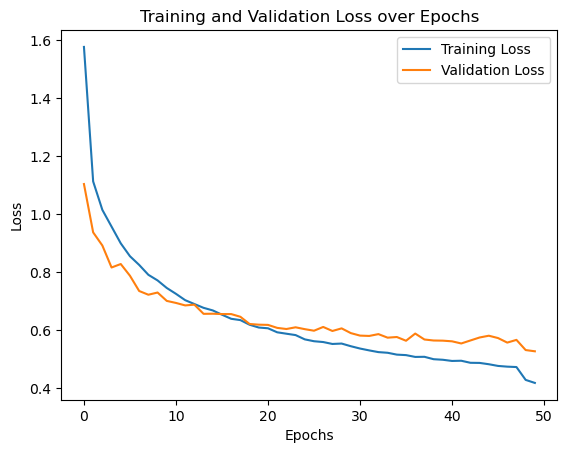

C:\Users\user\AppData\Local\Temp\ipykernel_25820\1245620458.py:135: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((targets - predictions) / targets)) * 100  # MAPE in percentage


Test MSE: 0.5229, Test RMSE: 0.7231, Test MAE: 0.4509, Test R²: 0.7785, Test MAPE: inf%


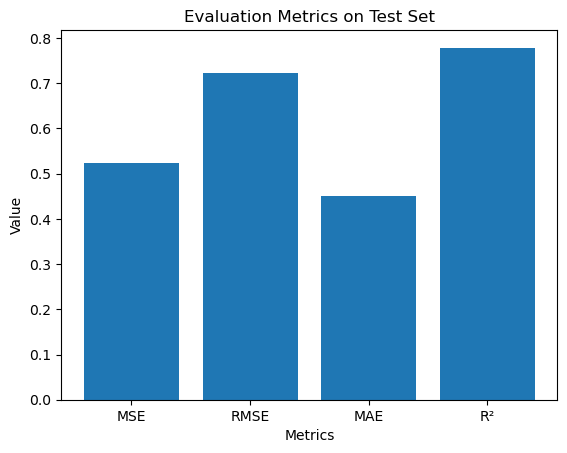

In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import optuna

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class
class KDDataset(Dataset):
    def __init__(self, data):
        self.drug_protein_embedding = data.iloc[:, 3:].values  # All embeddings (drug + protein)
        self.log_kd = data['Log_Kd'].values

    def __len__(self):
        return len(self.log_kd)

    def __getitem__(self, idx):
        return torch.tensor(self.drug_protein_embedding[idx], dtype=torch.float32), torch.tensor(self.log_kd[idx], dtype=torch.float32)

# Load datasets
def load_data(file_path):
    data = pd.read_csv(file_path)
    return KDDataset(data)

# Use the original directory paths as given in your code
train_file = os.path.join(working_dir, 'train_dataset1.csv')
val_file = os.path.join(working_dir, 'val_dataset1.csv')
test_file = os.path.join(working_dir, 'test_dataset1.csv')

# Load the datasets
train_dataset = load_data(train_file)
val_dataset = load_data(val_file)
test_dataset = load_data(test_file)

# DataLoader
def get_dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# FCNN Model (Keeping the original model name and structure)
class FCNN(nn.Module):
    def __init__(self, input_dim, layer_sizes, dropout_rate):
        super(FCNN, self).__init__()
        layers = []
        for i in range(len(layer_sizes)):
            layers.append(nn.Linear(input_dim if i == 0 else layer_sizes[i-1], layer_sizes[i]))
            layers.append(nn.BatchNorm1d(layer_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(layer_sizes[-1], 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to train and validate the model
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            drug_embedding, log_kd = batch
            drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
            
            optimizer.zero_grad()
            outputs = model(drug_embedding)
            loss = criterion(outputs.squeeze(), log_kd)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                drug_embedding, log_kd = batch
                drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
                outputs = model(drug_embedding)
                loss = criterion(outputs.squeeze(), log_kd)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(working_dir, 'fcnn_model1.pth'))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
        
        scheduler.step(val_loss)
    
    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in test_loader:
            drug_embedding, log_kd = batch
            drug_embedding, log_kd = drug_embedding.to(device), log_kd.to(device)
            outputs = model(drug_embedding)
            predictions.append(outputs.cpu().numpy())
            targets.append(log_kd.cpu().numpy())

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100  # MAPE in percentage

    print(f"Test MSE: {mse:.4f}, Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}, Test R²: {r2:.4f}, Test MAPE: {mape:.2f}%")
    
    return mse, rmse, mae, r2, mape

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    layer_sizes = trial.suggest_categorical('layer_sizes', [[512, 256], [1024, 512, 256], [2048, 1024, 512, 256]])
    
    # Create dataloaders
    train_loader = get_dataloader(train_dataset, batch_size, shuffle=True)
    val_loader = get_dataloader(val_dataset, batch_size, shuffle=False)
    
    # Instantiate the model
    input_dim = train_dataset[0][0].shape[0]
    model = FCNN(input_dim, layer_sizes, dropout_rate).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)
    
    # Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=10)
    
    # Return the best validation loss
    return min(val_losses)

# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print best parameters
print("Best hyperparameters:", study.best_params)

# Train the model with best parameters
best_params = study.best_params
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_layer_sizes = best_params['layer_sizes']
best_lr = best_params['lr']

# Create dataloaders with the best batch size
train_loader = get_dataloader(train_dataset, best_batch_size, shuffle=True)
val_loader = get_dataloader(val_dataset, best_batch_size, shuffle=False)
test_loader = get_dataloader(test_dataset, best_batch_size, shuffle=False)

# Instantiate the best model
model = FCNN(input_dim, best_layer_sizes, best_dropout_rate).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)

# Train the model with the best parameters
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=10)

# Load the best model
model.load_state_dict(torch.load(os.path.join(working_dir, 'fcnn_model1.pth')))

# Plot training and validation loss
def plot_training_history(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_training_history(train_losses, val_losses)

# Evaluate the model on the test set
mse, rmse, mae, r2, mape = evaluate_model(model, test_loader)

# Plot evaluation metrics
def plot_metrics(mse, rmse, mae, r2, mape):
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }
    plt.figure()
    plt.bar(metrics.keys(), metrics.values())
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Evaluation Metrics on Test Set')
    plt.show()

plot_metrics(mse, rmse, mae, r2, mape)

In [9]:
import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from rdkit import Chem
from rdkit.Chem import AllChem

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the working directory and file paths
new_drug_file = os.path.join(working_dir, 'New_drugs.csv')

# Load new drugs
new_drugs_df = pd.read_csv(new_drug_file)

################################### ChemBERTa Embeddings ###################################

# Load ChemBERTa model and tokenizer
tokenizer_chemberta = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model_chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(device)

# Function to extract ChemBERTa embeddings
def get_chemberta_embedding(smiles):
    inputs = tokenizer_chemberta(smiles, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model_chemberta(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

# Initialize lists to store embeddings
new_drug_embeddings = []

# Loop through each drug and extract ChemBERTa embeddings
for _, row in new_drugs_df.iterrows():
    smiles = row['Ligand SMILES']
    drug_id = row['DrugBank ID']
    
    # Get ChemBERTa embedding
    chemberta_emb = get_chemberta_embedding(smiles)
    
    # Store embedding with DrugBank ID
    new_drug_embeddings.append([drug_id] + chemberta_emb.tolist())

# Convert embeddings to DataFrame
chemberta_df = pd.DataFrame(new_drug_embeddings, columns=['DrugBank ID'] + [f'embedding_dim_{i+1}' for i in range(len(new_drug_embeddings[0]) - 1)])

# Save ChemBERTa embeddings to CSV
chemberta_output_file = os.path.join(working_dir, 'New_ChemBERT_drug_embeddings.csv')
chemberta_df.to_csv(chemberta_output_file, index=False)

print(f"ChemBERTa embeddings saved to {chemberta_output_file}")

################################### Morgan Fingerprints ###################################

# Function to compute Morgan fingerprints
def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)  # Return a zero vector for invalid SMILES
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Initialize list to store fingerprints
new_morgan_fingerprints = []

# Loop through each drug and compute Morgan fingerprints
for _, row in new_drugs_df.iterrows():
    smiles = row['Ligand SMILES']
    drug_id = row['DrugBank ID']
    
    # Get Morgan fingerprint
    morgan_fp = get_morgan_fingerprint(smiles)
    
    # Store fingerprint with DrugBank ID
    new_morgan_fingerprints.append([drug_id] + morgan_fp.tolist())

# Convert fingerprints to DataFrame
morgan_df = pd.DataFrame(new_morgan_fingerprints, columns=['DrugBank ID'] + [f'fingerprint_{i+1}' for i in range(len(new_morgan_fingerprints[0]) - 1)])

# Save Morgan fingerprints to CSV
morgan_output_file = os.path.join(working_dir, 'New_drug_morgan_fingerprints.csv')
morgan_df.to_csv(morgan_output_file, index=False)

print(f"Morgan fingerprints saved to {morgan_output_file}")

import os
import torch
import pandas as pd
from transformers import T5Tokenizer, T5EncoderModel
from tape import ProteinBertModel, TAPETokenizer

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_protein_file = os.path.join(working_dir, 'Book.csv')

# Load new proteins
new_proteins_df = pd.read_csv(new_protein_file)

################################### ProstT5 Embeddings ###################################

# Load ProstT5 tokenizer and model
tokenizer_prostt5 = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False)
model_prostt5 = T5EncoderModel.from_pretrained('Rostlab/ProstT5').to(device)

# Function to preprocess and tokenize protein sequences for ProstT5
def preprocess_and_tokenize_prostt5(sequences):
    sequences = [" ".join(list(seq)) for seq in sequences]  # Add space between each amino acid
    sequences = ["<AA2fold> " + seq for seq in sequences]   # Add special token "<AA2fold>"
    return tokenizer_prostt5.batch_encode_plus(sequences, add_special_tokens=True, padding="longest", return_tensors='pt').to(device)

# Function to extract ProstT5 embeddings
def extract_prostt5_embeddings(sequences):
    tokenized_seqs = preprocess_and_tokenize_prostt5(sequences)
    with torch.no_grad():
        embeddings = model_prostt5(input_ids=tokenized_seqs.input_ids, attention_mask=tokenized_seqs.attention_mask)
    per_protein_embeddings = []
    for i in range(len(sequences)):
        seq_len = (tokenized_seqs.attention_mask[i] == 1).sum() - 1  # Exclude padding
        per_protein_emb = embeddings.last_hidden_state[i, 1:seq_len+1].mean(dim=0).cpu().numpy()  # Mean pooling
        per_protein_embeddings.append(per_protein_emb)
    return per_protein_embeddings

# Extract ProstT5 embeddings for all proteins
new_protein_embeddings_prostt5 = []
for _, row in new_proteins_df.iterrows():
    sequence = row['Sequence']
    protein_id = row['UniProt ID']
    
    # Extract ProstT5 embedding
    prostt5_emb = extract_prostt5_embeddings([sequence])[0]
    
    # Store embedding with UniProt ID
    new_protein_embeddings_prostt5.append([protein_id] + prostt5_emb.tolist())

# Convert ProstT5 embeddings to DataFrame
prostt5_df = pd.DataFrame(new_protein_embeddings_prostt5, columns=['UniProt ID'] + [f'embedding_dim_{i+1}' for i in range(len(new_protein_embeddings_prostt5[0]) - 1)])

# Save ProstT5 embeddings to CSV
prostt5_output_file = os.path.join(working_dir, 'New_protein_prostt5_embeddings.csv')
prostt5_df.to_csv(prostt5_output_file, index=False)

print(f"ProstT5 embeddings saved to {prostt5_output_file}")

################################### TAPE Embeddings ###################################

# Load TAPE tokenizer and model
tokenizer_tape = TAPETokenizer(vocab="iupac")
model_tape = ProteinBertModel.from_pretrained("bert-base")

# Function to extract TAPE embeddings
def extract_tape_embeddings(sequence):
    tokens = tokenizer_tape.tokenize(sequence)
    input_ids = torch.tensor([tokenizer_tape.convert_tokens_to_ids(tokens)]).to(torch.long)
    with torch.no_grad():
        outputs = model_tape(input_ids)
    return outputs[0].mean(dim=1).squeeze().cpu().numpy()  # Mean pooling over the tokens

# Extract TAPE embeddings for all proteins
new_protein_embeddings_tape = []
for _, row in new_proteins_df.iterrows():
    sequence = row['Sequence']
    protein_id = row['UniProt ID']
    
    # Extract TAPE embedding
    tape_emb = extract_tape_embeddings(sequence)
    
    # Store embedding with UniProt ID
    new_protein_embeddings_tape.append([protein_id] + tape_emb.tolist())

# Convert TAPE embeddings to DataFrame
tape_df = pd.DataFrame(new_protein_embeddings_tape, columns=['UniProt ID'] + [f'embedding_dim_{i+1}' for i in range(len(new_protein_embeddings_tape[0]) - 1)])

# Save TAPE embeddings to CSV
tape_output_file = os.path.join(working_dir, 'New_protein_tape_embeddings.csv')
tape_df.to_csv(tape_output_file, index=False)

print(f"TAPE embeddings saved to {tape_output_file}")

import pandas as pd
import os
from itertools import product

# Load the drugs and proteins data into pandas dataframes
drugs_df = pd.read_csv(os.path.join(working_dir, 'New_drugs.csv'))  # New set of drugs
proteins_df = pd.read_csv(os.path.join(working_dir, 'Book.csv'))  # New set of proteins

# Generate all possible combinations of drug and protein pairs using Cartesian product
all_pairs = list(product(drugs_df['DrugBank ID'], proteins_df['UniProt ID']))

# Create a dataframe to store these pairs
pairs_df = pd.DataFrame(all_pairs, columns=['DrugBank ID', 'UniProt ID'])

# Save the pairs to a CSV file
pairs_file = os.path.join(working_dir, 'all_drug_protein_pairs.csv')
pairs_df.to_csv(pairs_file, index=False)

print(f"All possible drug-protein pairs saved to: {pairs_file}")

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Step 1: Define AttentionCombiner class
class AttentionCombiner(nn.Module):
    def __init__(self, chemberta_dim, morgan_dim, prostt5_dim, tape_dim):
        super(AttentionCombiner, self).__init__()
        self.chemberta_fc = nn.Linear(chemberta_dim, chemberta_dim)
        self.morgan_fc = nn.Linear(morgan_dim, morgan_dim)
        self.prostt5_fc = nn.Linear(prostt5_dim, prostt5_dim)
        self.tape_fc = nn.Linear(tape_dim, tape_dim)
        
        # Attention layer to learn the importance of different embeddings
        self.attention_layer = nn.Linear(chemberta_dim + morgan_dim + prostt5_dim + tape_dim, 1)

    def forward(self, chemberta, morgan, prostt5, tape):
        # Apply linear layers to each type of embedding
        chemberta = self.chemberta_fc(chemberta)
        morgan = self.morgan_fc(morgan)
        prostt5 = self.prostt5_fc(prostt5)
        tape = self.tape_fc(tape)
        
        # Concatenate embeddings
        combined = torch.cat([chemberta, morgan, prostt5, tape], dim=1)
        
        # Apply attention weights
        attention_weights = torch.softmax(self.attention_layer(combined), dim=1)
        
        # Compute the final combined embedding
        combined_embedding = attention_weights * combined
        return combined_embedding

# File paths for separate embeddings and drug-protein pairs
pair_file = os.path.join(working_dir, 'all_drug_protein_pairs.csv')  # Generated drug-protein pair file
chemberta_file = os.path.join(working_dir, 'New_ChemBERT_drug_embeddings.csv')
morgan_file = os.path.join(working_dir, 'New_drug_morgan_fingerprints.csv')
prostt5_file = os.path.join(working_dir, 'New_protein_prostt5_embeddings.csv')
tape_file = os.path.join(working_dir, 'New_protein_tape_embeddings.csv')

# Step 3: Load the separate embeddings and the pairs file
pairs_df = pd.read_csv(pair_file)
chemberta_df = pd.read_csv(chemberta_file)
morgan_df = pd.read_csv(morgan_file)
prostt5_df = pd.read_csv(prostt5_file)
tape_df = pd.read_csv(tape_file)

# Extract embedding columns for each type
chemberta_cols = [col for col in chemberta_df.columns if 'embedding_dim_' in col]
morgan_cols = [col for col in morgan_df.columns if 'fingerprint_' in col]
prostt5_cols = [col for col in prostt5_df.columns if 'embedding_dim_' in col]
tape_cols = [col for col in tape_df.columns if 'embedding_dim_' in col]

# Step 4: Z-score normalization for ChemBERTa, ProstT5, and TAPE embeddings (Morgan remains unchanged)
scaler_chemberta = StandardScaler()
scaler_prostt5 = StandardScaler()
scaler_tape = StandardScaler()

chemberta_df[chemberta_cols] = scaler_chemberta.fit_transform(chemberta_df[chemberta_cols])
prostt5_df[prostt5_cols] = scaler_prostt5.fit_transform(prostt5_df[prostt5_cols])
tape_df[tape_cols] = scaler_tape.fit_transform(tape_df[tape_cols])

# Step 5: Initialize lists to store mapped embeddings
mapped_chemberta = []
mapped_morgan = []
mapped_prostt5 = []
mapped_tape = []
drug_ids = []
protein_ids = []

# Step 6: Map embeddings to drug-protein pairs
for _, pair in pairs_df.iterrows():
    drug_id = pair['DrugBank ID']
    protein_id = pair['UniProt ID']
    
    # Find the row in each embedding DataFrame based on DrugBank ID and UniProt ID
    drug_row_chemberta = chemberta_df[chemberta_df['DrugBank ID'] == drug_id]
    drug_row_morgan = morgan_df[morgan_df['DrugBank ID'] == drug_id]
    protein_row_prostt5 = prostt5_df[prostt5_df['UniProt ID'] == protein_id]
    protein_row_tape = tape_df[tape_df['UniProt ID'] == protein_id]
    
    if drug_row_chemberta.empty or drug_row_morgan.empty or protein_row_prostt5.empty or protein_row_tape.empty:
        continue  # Skip if no matching row is found
    
    # Extract embeddings for the drug and protein
    chemberta_embedding = drug_row_chemberta[chemberta_cols].values.flatten()
    morgan_embedding = drug_row_morgan[morgan_cols].values.flatten()
    prostt5_embedding = protein_row_prostt5[prostt5_cols].values.flatten()
    tape_embedding = protein_row_tape[tape_cols].values.flatten()
    
    # Append embeddings to lists
    mapped_chemberta.append(chemberta_embedding)
    mapped_morgan.append(morgan_embedding)
    mapped_prostt5.append(prostt5_embedding)
    mapped_tape.append(tape_embedding)
    drug_ids.append(drug_id)
    protein_ids.append(protein_id)

# Step 7: Convert mapped embeddings to PyTorch tensors
chemberta_tensor = torch.tensor(np.array(mapped_chemberta), dtype=torch.float32)
morgan_tensor = torch.tensor(np.array(mapped_morgan), dtype=torch.float32)
prostt5_tensor = torch.tensor(np.array(mapped_prostt5), dtype=torch.float32)
tape_tensor = torch.tensor(np.array(mapped_tape), dtype=torch.float32)

# Step 8: Initialize the AttentionCombiner and combine embeddings
combiner = AttentionCombiner(
    chemberta_dim=len(chemberta_cols),
    morgan_dim=len(morgan_cols),
    prostt5_dim=len(prostt5_cols),
    tape_dim=len(tape_cols)
)

# Apply attention mechanism to combine embeddings
combined_embeddings = []
with torch.no_grad():
    for i in range(chemberta_tensor.size(0)):
        combined_emb = combiner(
            chemberta_tensor[i].unsqueeze(0),
            morgan_tensor[i].unsqueeze(0),
            prostt5_tensor[i].unsqueeze(0),
            tape_tensor[i].unsqueeze(0)
        ).squeeze(0).cpu().numpy().flatten()
        combined_embeddings.append(combined_emb)

# Step 9: Save combined embeddings with drug-protein pairs
combined_embeddings_df = pd.DataFrame(combined_embeddings)
combined_embeddings_df.insert(0, 'DrugBank ID', drug_ids)
combined_embeddings_df.insert(1, 'UniProt ID', protein_ids)

# Save the combined embeddings to a CSV file
combined_embeddings_file = os.path.join(working_dir, 'combined_drug_protein_embeddings.csv')
combined_embeddings_df.to_csv(combined_embeddings_file, index=False)

print(f"Combined embeddings saved to: {combined_embeddings_file}")

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ChemBERTa embeddings saved to C:\Users\user\Desktop\Pratanu\DB2\New_ChemBERT_drug_embeddings.csv


[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerator
[11:02:44] DEPRECATION WARNING: please use MorganGenerat

Morgan fingerprints saved to C:\Users\user\Desktop\Pratanu\DB2\New_drug_morgan_fingerprints.csv


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ProstT5 embeddings saved to C:\Users\user\Desktop\Pratanu\DB2\New_protein_prostt5_embeddings.csv


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tape\models\modeling_utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolve

TAPE embeddings saved to C:\Users\user\Desktop\Pratanu\DB2\New_protein_tape_embeddings.csv
All possible drug-protein pairs saved to: C:\Users\user\Desktop\Pratanu\DB2\all_drug_protein_pairs.csv
Combined embeddings saved to: C:\Users\user\Desktop\Pratanu\DB2\combined_drug_protein_embeddings.csv


In [8]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# FCNN Model Definition (same as in your training script)
class FCNN(nn.Module):
    def __init__(self, input_dim, layer_sizes, dropout_rate):
        super(FCNN, self).__init__()
        layers = []
        for i in range(len(layer_sizes)):
            layers.append(nn.Linear(input_dim if i == 0 else layer_sizes[i-1], layer_sizes[i]))
            layers.append(nn.BatchNorm1d(layer_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(layer_sizes[-1], 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Step 1: Load the combined embeddings
combined_embeddings_file = os.path.join(working_dir, 'combined_drug_protein_embeddings.csv')  # Path to embeddings
combined_embeddings_df = pd.read_csv(combined_embeddings_file)

# Step 2: Initialize the pretrained model with the same architecture as used in training
input_dim = combined_embeddings_df.shape[1] - 2  # Subtract 2 for 'DrugBank ID' and 'UniProt ID' columns
layer_sizes = [1024, 512, 256]  # You should use the same architecture as training
dropout_rate = 0.3  # Use the same dropout rate as training

# Instantiate the model
model = FCNN(input_dim, layer_sizes, dropout_rate).to(device)

# Step 3: Load the pretrained model weights
model_file = os.path.join(working_dir, 'fcnn_model1.pth')
model.load_state_dict(torch.load(model_file))
model.eval()  # Set the model to evaluation mode

# Step 4: Prepare the data for prediction
embedding_columns = [col for col in combined_embeddings_df.columns if col not in ['DrugBank ID', 'UniProt ID']]
embeddings_tensor = torch.tensor(combined_embeddings_df[embedding_columns].values, dtype=torch.float32).to(device)

# Step 5: Make predictions
with torch.no_grad():
    predicted_kd_values = model(embeddings_tensor).cpu().squeeze().numpy()  # Ensure CPU for saving predictions

# Step 6: Store predictions along with drug-protein pairs
predictions_df = combined_embeddings_df[['DrugBank ID', 'UniProt ID']].copy()
predictions_df['Predicted_Kd'] = predicted_kd_values

# Save the predictions to CSV
predictions_output_file = os.path.join(working_dir, 'predicted_kd_values.csv')
predictions_df.to_csv(predictions_output_file, index=False)
print(f"Predicted Kd values saved to {predictions_output_file}")

C:\Users\user\AppData\Local\Temp\ipykernel_25820\3868871621.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


Predicted Kd values saved to C:\Users\user\Desktop\Pratanu\DB2\predicted_kd_values.csv
